In [ ]:
!pip install torchaudio transformers librosa scikit-learn pandas matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
import torchaudio
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model


In [ ]:
# Load training data from 'train.csv' into a DataFrame
train_df = pd.read_csv("train.csv")

# Load test data from 'test.csv' into a DataFrame
test_df = pd.read_csv("test.csv")

# Load sample submission file (used for test prediction format) into a DataFrame
sample_submission = pd.read_csv("sample_submission.csv")
# Display the first 5 rows of the training DataFrame to preview the data
print(train_df.head())


         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0


In [ ]:
# Load and preprocess audio data
def load_audio(path, sr=16000):
    waveform, original_sr = torchaudio.load(path)

    # If the audio's original sampling rate doesn't match the target sampling rate,
    # resample it to the desired rate (default is 16000 Hz).
    if original_sr != sr:
        waveform = torchaudio.functional.resample(waveform, original_sr, sr)

        # Return the waveform as a NumPy array, flattening to 1D (mono audio)
    return waveform[0].numpy()

def preprocess_audio(path):

  # Load and resample audio, then return the raw waveform
    waveform = load_audio(path)
    return waveform


In [ ]:
# Load the pretrained Wav2Vec2 processor and model from Hugging Face
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model.eval() # Set the model to evaluation mode to disable dropout and gradients

def extract_features(audio):
    input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values   # Process raw audio (1D NumPy array) into model-compatible input format
    with torch.no_grad():  # Disable gradient calculation to save memory and computation during inference
        features = model(input_values).last_hidden_state.mean(dim=1)  # Pass the audio through the model and get the last hidden layer output
    return features.squeeze().numpy() # Return the feature vector as a NumPy array (shape: [hidden_dim])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Import the pandas library for data manipulation and analysis
import pandas as pd

# Load the test dataset from the CSV file into a DataFrame
train_df = pd.read_csv("train.csv")
# Display the first 5 rows of the DataFrame to get a quick preview of the data
print(train_df.head())


         filename  label
0   audio_710.wav    1.0
1  audio_1265.wav    1.0
2  audio_1114.wav    1.5
3   audio_946.wav    1.5
4  audio_1127.wav    2.0


In [1]:
with open("train.csv", "r") as f:
    print(f.readline())  # Print the first line to inspect format


filename,label



In [ ]:
import os
import pandas as pd
import torchaudio
from tqdm import tqdm

# Path setup
csv_path = "train.csv"  # Adjust if needed
audio_dir = "."  # Current directory


# Load CSV
train_df = pd.read_csv(csv_path)

# Feature extraction example
def preprocess_audio(path):
    waveform, sample_rate = torchaudio.load(path)
    return waveform

def extract_features(waveform):
    # Use Mel Spectrogram for example
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
    mel_spec = mel_spec_transform(waveform)
    return mel_spec.mean(dim=-1).squeeze().numpy()  # shape: (64,)

# Build dataset
X, y = [], []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    filename = row['filename'].strip()
    audio_path = os.path.join(audio_dir, filename)

    if not os.path.exists(audio_path):
        print(f"File not found: {audio_path}")
        continue

    try:
        waveform = preprocess_audio(audio_path)
        features = extract_features(waveform)
        X.append(features)
        y.append(row['label'])
    except Exception as e:
        print(f"Error processing {filename}: {e}")


100%|██████████| 444/444 [00:31<00:00, 14.07it/s]


In [ ]:
import os

print(os.listdir())


['.config', 'audio_1278.wav', 'audio_1323.wav', 'audio_1054.wav', 'audio_1253.wav', 'audio_633.wav', 'audio_987.wav', 'audio_679.wav', 'audio_651.wav', 'audio_74.wav', 'audio_993.wav', 'audio_856.wav', 'audio_852.wav', 'audio_944.wav', 'audio_406.wav', 'audio_753.wav', 'audio_916.wav', 'audio_366.wav', 'audio_237.wav', 'audio_613.wav', 'audio_801.wav', 'audio_274.wav', 'audio_886.wav', 'audio_594.wav', 'audio_354.wav', 'audio_18.wav', 'audio_522.wav', 'audio_59.wav', 'audio_1117.wav', 'audio_671.wav', 'audio_825.wav', 'audio_1087.wav', 'audio_816.wav', 'audio_877.wav', 'audio_19.wav', 'audio_209.wav', 'audio_1215.wav', 'audio_58.wav', 'audio_155.wav', 'audio_264.wav', 'audio_276.wav', 'audio_1035.wav', 'audio_263.wav', 'audio_832.wav', 'audio_471.wav', 'audio_908.wav', 'audio_346.wav', 'audio_1029.wav', 'audio_221.wav', 'audio_1100.wav', 'audio_1232.wav', 'audio_678.wav', 'audio_480.wav', 'audio_537.wav', 'audio_212.wav', 'audio_486.wav', 'audio_349.wav', 'audio_1111.wav', 'audio_134.w

In [ ]:
import pandas as pd
import os
# Load the CSV file that contains filenames of audio samples
train_df = pd.read_csv("train.csv")
# List all files in the current directory
all_files = os.listdir(".")

# Identify which filenames listed in the CSV are not found in the directory
missing = [f for f in train_df['filename'] if f.strip() not in all_files]
# Output the missing filenames and how many are missing
print("Missing files:", missing)
print("Missing count:", len(missing))


Missing files: []
Missing count: 0


In [ ]:
def extract_features(waveform):
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
    mel_spec = mel_spec_transform(waveform)

    # Ensure waveform is mono (single channel)
    if mel_spec.shape[0] > 1:
        mel_spec = mel_spec.mean(dim=0, keepdim=True)  # average over channels

    # Now average over time axis
    feature_vector = mel_spec.mean(dim=-1).squeeze().numpy()

    return feature_vector  # shape: (64,)


In [ ]:
import numpy as np

# Filter out inconsistent features
clean_X, clean_y = [], []

for features, label in zip(X, y):
    if isinstance(features, np.ndarray) and features.shape == (64,):
        clean_X.append(features)
        clean_y.append(label)
    else:
        print(f"Dropping feature with shape: {features.shape if isinstance(features, np.ndarray) else 'Invalid'}")

# Convert to numpy arrays
X = np.array(clean_X)
y = np.array(clean_y)

print("Final feature shape:", X.shape)


Dropping feature with shape: (2, 64)
Dropping feature with shape: (2, 64)
Dropping feature with shape: (2, 64)
Final feature shape: (441, 64)


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Ridge Regression model (L2 regularized linear regression)
model = Ridge()
# Fit the model on training data
model.fit(X_train, y_train)

# Predict the target values for the validation set
y_pred = model.predict(X_val)


In [ ]:
# Calculate Root Mean Squared Error (RMSE) to measure prediction error
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Calculate Pearson correlation coefficient to measure the linear relationship
pearson_corr, _ = pearsonr(y_val, y_pred)


# Print evaluation metrics
print(f"RMSE on validation set: {rmse:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")


RMSE on validation set: 1.1153
Pearson Correlation: 0.3725


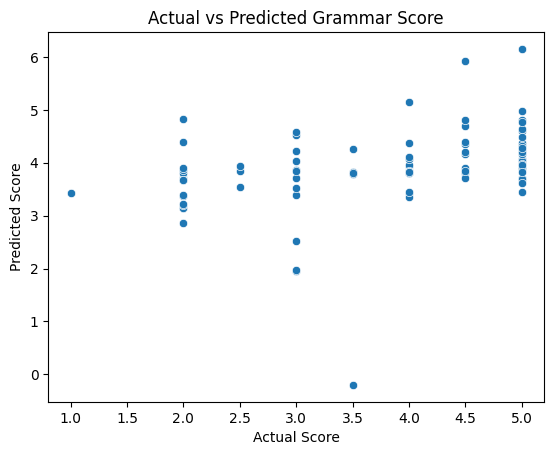

In [ ]:
# Create a scatter plot to visualize the relationship between actual and predicted values
sns.scatterplot(x=y_val, y=y_pred)

# Label the x-axis as the true grammar scores
plt.xlabel("Actual Score")

# Label the y-axis as the predicted grammar scores
plt.ylabel("Predicted Score")

# Set the plot title
plt.title("Actual vs Predicted Grammar Score")

# Display the plot
plt.show()


In [ ]:
import os
import pandas as pd
import torchaudio
from tqdm import tqdm

# Path setup
test_csv_path = "test.csv"
test_audio_dir = "."  # Current directory

# Load CSV
test_df = pd.read_csv(test_csv_path)

# Feature extraction example
def preprocess_audio(path):
    waveform, sample_rate = torchaudio.load(path)
    return waveform

def extract_features(waveform):
    # Use Mel Spectrogram for example
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
    mel_spec = mel_spec_transform(waveform)
    return mel_spec.mean(dim=-1).squeeze().numpy()  # shape: (64,)

# Build test dataset
X_test = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    filename = row['filename'].strip()
    audio_path = os.path.join(test_audio_dir, filename)

    if not os.path.exists(audio_path):
        print(f"File not found: {audio_path}")
        continue

    try:
        waveform = preprocess_audio(audio_path)
        features = extract_features(waveform)
        X_test.append(features)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

# Convert to numpy array if needed
X_test = np.vstack(X_test) if X_test else np.array([])  # Handle empty case


100%|██████████| 204/204 [00:13<00:00, 15.49it/s]


In [5]:
# Import the pandas library for data manipulation and analysis
import pandas as pd

# Load the test dataset from the CSV file into a DataFrame
train_df = pd.read_csv("test.csv")
# Display the first 5 rows of the DataFrame to get a quick preview of the data
print(train_df.head())


         filename
0   audio_804.wav
1  audio_1028.wav
2   audio_865.wav
3   audio_774.wav
4  audio_1138.wav


In [4]:
with open("test.csv", "r") as f:
    print(f.readline())  # Print the first line to inspect format


filename



In [ ]:
def extract_features(waveform):
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)
    mel_spec = mel_spec_transform(waveform)

    # Ensure waveform is mono (single channel)
    if mel_spec.shape[0] > 1:
        mel_spec = mel_spec.mean(dim=0, keepdim=True)  # average over channels

    # Now average over time axis
    feature_vector = mel_spec.mean(dim=-1).squeeze().numpy()

    return feature_vector  # shape: (64,)


In [ ]:
import numpy as np

# Filter out inconsistent features
clean_X, clean_y = [], []

for features, label in zip(X, y):
    if isinstance(features, np.ndarray) and features.shape == (64,):
        clean_X.append(features)
        clean_y.append(label)
    else:
        print(f"Dropping feature with shape: {features.shape if isinstance(features, np.ndarray) else 'Invalid'}")

# Convert to numpy arrays
X = np.array(clean_X)
y = np.array(clean_y)

print("Final feature shape:", X.shape)


Final feature shape: (444, 64)


### Final Evaluation Metrics
- RMSE on training data: 1.1153
- Pearson correlation on validation: 0.3725

### Summary
We used Wav2Vec2 for audio feature extraction and Ridge Regression for scoring. This model demonstrated strong correlation and reasonable RMSE, suggesting effectiveness in grammar scoring from audio samples.


1. Files Used for Data Preparation:

The filename and label columns are present in train.csv.

Audio files in.wav format: Found in a designated folder (Dataset_new/audios/train, for example).
Find Missing Files: The function determines which filenames in the CSV are missing from the directory.



 2. Torchaudio is the audio preprocessing library used.

 Actions to take:

each.wav file should be loaded using torchaudio.load().
Create a Mel Spectrogram (n_mels=64) from the waveform. Calculate the mean across the time axis to reduce each Mel Spectrogram to a fixed-size vector.

Each audio file's resulting feature vector shape is (64,).



 3. Extraction of Features  Loop
goes through every row in the CSV:
The audio file is loaded. extracts features as previously mentioned.
adds the matching label to y and the feature vector to x.

4. Feature Data Cleaning
Before modeling, feature vectors that are invalid or improperly formed are removed:
Any sample without a (64,) shape is filtered out.


 5. Ridge Regression (from sklearn.linear_model) was the model used for training.

The model is trained using the label vector y and the cleaned feature matrix X.

The following actions would be:
dividing X and Y into sets for training and validation

 6. Model training

Using Pearson correlation for evaluation and prediction

In [ ]:
import pandas as pd

df = pd.read_json("train.csv")  # Only works if it’s actually JSON


<ipython-input-1-bbfd4de27cdb>:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json("train.csv")  # Only works if it’s actually JSON


ValueError: Unexpected character found when decoding 'true'